# Feature Engineering
Transform data into factors

1. Load the data downloaded from freqtrade as usual. 

In [1]:
import os
from pathlib import Path

# Change directory
# Modify this cell to insure that the output shows the correct path.
# Define all paths relative to the project root shown in the cell output
project_root = ""
i=0
try:
    os.chdir(project_root)
    assert Path('LICENSE').is_file()
except:
    while i<4 and (not Path('LICENSE').is_file()):
        os.chdir(Path(Path.cwd(), '../'))
        i+=1
    project_root = Path.cwd()
print(Path.cwd())

/freqtrade


In [3]:
from freqtrade.configuration import Configuration

# Customize these according to your needs.

# Initialize empty configuration object
# config = Configuration.from_files([])
# Optionally (recommended), use existing configuration file
config = Configuration.from_files(["user_data/config.json"])

# Define some constants
config["timeframe"] = "15m"
# Name of the strategy class
config["strategy"] = "MeanReversionStrategy"
# Location of the data
data_location = config["datadir"]
# Pair to analyze - Only use one pair here
pair = "SUI/USDT:USDT"
print(data_location)

/freqtrade/user_data/data/binance


In [4]:
# Load data using values set above
from freqtrade.data.history import load_pair_history
from freqtrade.enums import CandleType

candles = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair=pair,
                            data_format = "feather",  # Make sure to update this to your data
                            candle_type=CandleType.FUTURES,
                            )

# Confirm success
print(f"Loaded {len(candles)} rows of data for {pair} from {data_location}")
candles.head()

Loaded 36191 rows of data for SUI/USDT:USDT from /freqtrade/user_data/data/binance


,date,open,high,low,close,volume
0,2023-05-03 16:00:00+00:00,1.4030,1.4030,1.2652,1.3338,11474534.0
1,2023-05-03 16:15:00+00:00,1.3339,1.3863,1.3327,1.3716,16090260.4
2,2023-05-03 16:30:00+00:00,1.3717,1.3957,1.3547,1.3857,13192974.2
3,2023-05-03 16:45:00+00:00,1.3866,1.3924,1.3652,1.3733,11951258.0
4,2023-05-03 17:00:00+00:00,1.3731,1.3756,1.3405,1.3574,12698235.4


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
%matplotlib inline

from datetime import datetime
import pandas as pd
# import pandas_datareader.data as web

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [16]:
outlier_cutoff = 0.01
data = candles.copy() # deep copy of candles
lags = [1, 2, 4, 8, 12, 16]
df = pd.DataFrame()

for lags in lags:
    df[f'return_{lags}'] = (data['close'].pct_change(lags)
                                        .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                               upper=x.quantile(1-outlier_cutoff)))
                                        .add(1)
                                        .pow(1/lags)
                                        .sub(1)
                                        )       


df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 36175 entries, 16 to 36190
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   return_1   36175 non-null  float64
 1   return_2   36175 non-null  float64
 2   return_4   36175 non-null  float64
 3   return_8   36175 non-null  float64
 4   return_12  36175 non-null  float64
 5   return_16  36175 non-null  float64
dtypes: float64(6)
memory usage: 1.9 MB
None


In [17]:
df.describe()

,return_1,return_2,return_4,return_8,return_12,return_16
count,36175.000000,36175.000000,36175.000000,36175.000000,3.617500e+04,36175.000000
mean,0.000027,0.000015,0.000007,0.000002,-7.093754e-07,-0.000002
std,0.005413,0.003865,0.002719,0.001904,1.555268e-03,0.001349
min,-0.016369,-0.011773,-0.008104,-0.005584,-4.523352e-03,-0.003790
25%,-0.002856,-0.002001,-0.001379,-0.000987,-8.169653e-04,-0.000733
50%,0.000000,0.000000,0.000000,-0.000016,-1.425832e-05,-0.000024
75%,0.002854,0.001965,0.001347,0.000936,7.584760e-04,0.000652
max,0.016894,0.012263,0.008620,0.006079,4.927133e-03,0.004269


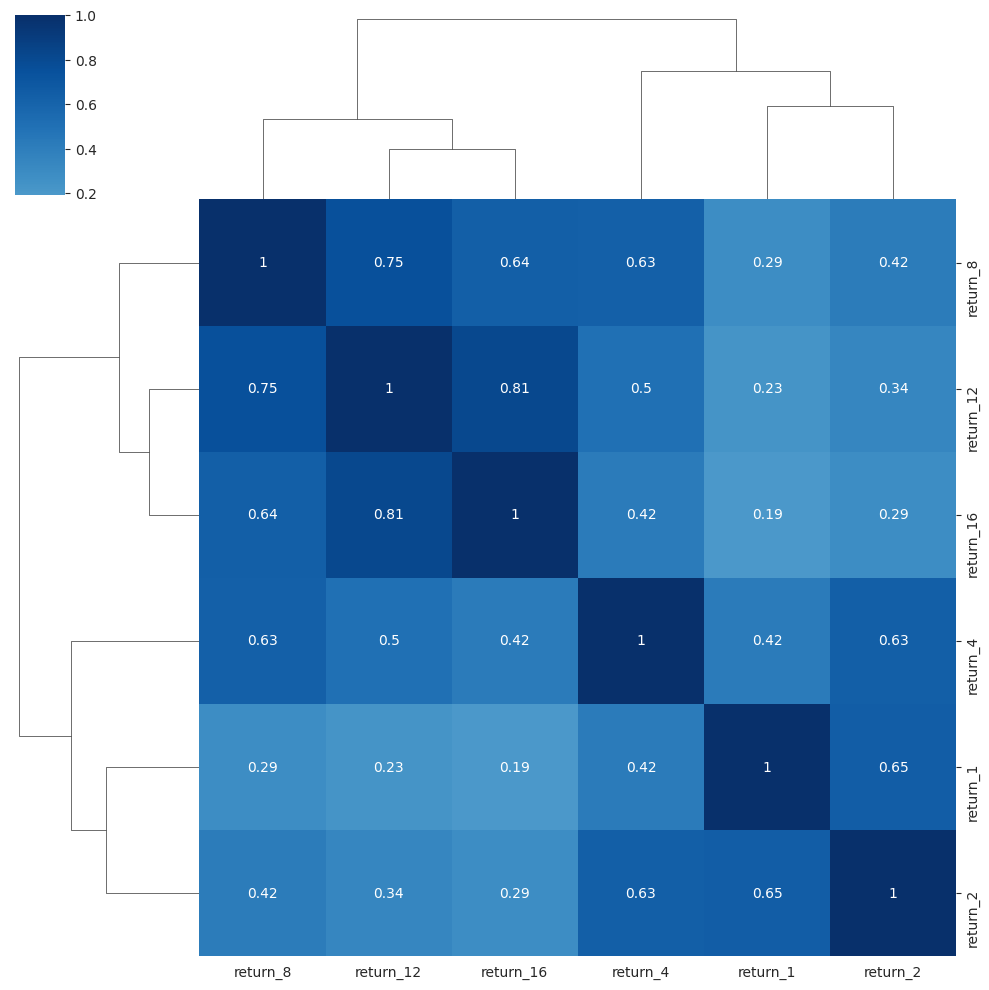

In [18]:
sns.clustermap(df.corr('spearman'), annot=True, center=0, cmap='Blues');